In [99]:
import numpy as np
import matplotlib.pyplot as plt
import math


- RBFカーネル (Radial basis function, 動径基底関数)
$$ k(x,x') = \theta_1 \exp{\left( -\frac{|x-x'|^2}{\theta_2} \right)} $$


- 線形カーネル (Linear kernel)
$$ k(x,x') = x^T x' $$


- 指数カーネル (Exponential kernel)
$$ k(x,x') = \exp{\left( -\frac{|x-x'|}{\theta} \right)} $$


- 周期カーネル (Periodic kernel)
$$ k(x,x') = \exp{\left( \theta_1 \cos{\left( -\frac{|x-x'|^2}{\theta_2} \right)} \right)} $$


In [100]:
# RBFカーネル (Radial basis function, 動径基底関数)
def k_RBF(x1, x2, t1, t2):
    return t1 * math.exp(((x1-x2)**2)/(-t2))

# 線形カーネル (Linear kernel)
def k_linear(x1, x2):
    return x1 * x2

# 指数カーネル (Exponential kernel)
def k_exp(x1, x2, t1):
    return math.exp(abs(x1-x2)/(-t1))

# 周期カーネル (Periodic kernel)
def k_periodic(x1, x2, t1, t2):
    return math.exp(t1*math.cos(abs(x1-x2)/t2))

In [101]:
# 共分散行列K
def make_K(x, t1=1.0, t2=1.0, kernel='rbf'):
    l = len(x)
    K = []
    for i in range(l):
        ki = []
        for j in range(l):
            if kernel == 'linear':
                ki = ki + [k_linear(x[i],x[j])]
            elif kernel == 'exp':
                ki = ki + [k_exp(x[i],x[j],t1)]
            elif kernel == 'periodic':
                ki = ki + [k_periodic(x[i],x[j],t1,t2)]
            else:
                ki = ki + [k_RBF(x[i],x[j],t1,t2)]
        K = K + [ki] 
        
    return K

In [102]:
x = [1.0]
for i in range(1,15):
    x += [x[i-1]+0.2]


In [103]:
K = make_K(x)
#print(np.matrix(K))

#コレスキー分解
L = np.linalg.cholesky(K)



In [104]:
# N(0, 1.0) のガウス分布
N = np.random.normal(0, 1.0, len(x))
y = L @ N

In [105]:
print(y)

[-0.34833383 -0.77633374 -1.02417666 -1.11936579 -1.1414721  -1.1550313
 -1.15781584 -1.08641924 -0.87639645 -0.52873599 -0.12793393  0.2034888
  0.37651291  0.37791686  0.26095456]


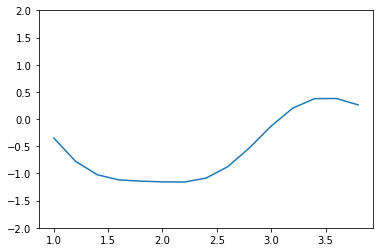

In [106]:
#ガウス過程の関数のうち1つを出力
plt.figure()
plt.ylim(-2.0,2.0)
plt.plot(x,y)

In [107]:
#コレスキー分解で得た分散共分散行列の下三角行列Lから多次元ガウス分布を出力

def viz_gp(x,L,title):
    Y = []
    n = 9
    for i in range(n):
        N = np.random.normal(0, 1.0, len(x))
        yi = L @ N
        Y += [yi]

    plt.figure()
    plt.ylim(-5.0,5.0)
    plt.title(title)
    for i in range(n):
        plt.plot(x,Y[i])


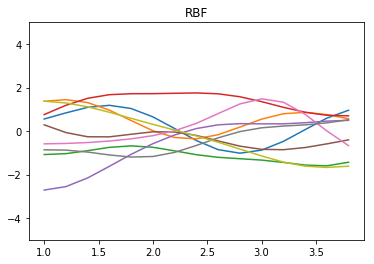

In [108]:
#関数を8本ずつ出力 (再実行で別の関数を出力)
#RBFカーネル

K_rbf = make_K(x)

#コレスキー分解
L_rbf = np.linalg.cholesky(K_rbf)
viz_gp(x,L_rbf,'RBF')

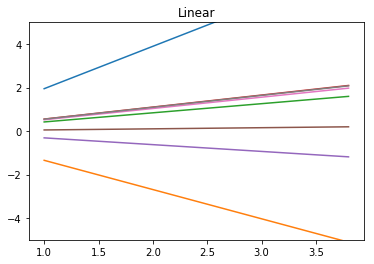

In [12]:
#線形カーネル

K_li = make_K(x, kernel='linear')

#多次元ガウス分布
y = np.random.multivariate_normal([0]*15, K_li, 9)
plt.figure()
plt.ylim(-5.0,5.0)
plt.title('Linear')
for i in range(8):
    plt.plot(x,y[i])


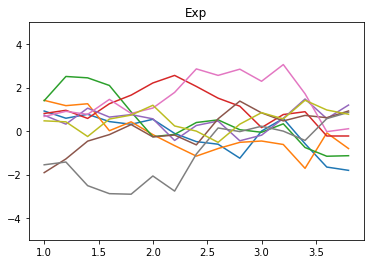

In [109]:
#指数カーネル

K_exp = make_K(x, kernel='exp')

#コレスキー分解
L_exp = np.linalg.cholesky(K_exp)
viz_gp(x,L_exp,'Exp')

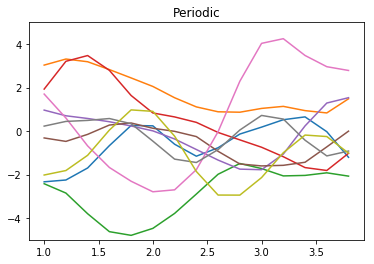

In [110]:
#周期カーネル

K_pe = make_K(x, t2=1/2, kernel='periodic')

#コレスキー分解
L_pe = np.linalg.cholesky(K_pe)
viz_gp(x,L_pe,'Periodic')

- ガウス過程回帰
(※観測ノイズは未実装)

In [86]:
def gp_pred(x0,x,y,K):
    kk = k_RBF(x0,x0,1.0,1.0)
    k = []
    for i in x:
        k += [k_RBF(x0,i,1.0,1.0)]
        #k += [k_periodic(x0,i,1.0,1.0)]
    temp = np.matrix(k) @ np.matrix(K).I @ np.matrix(y).T
    mu = temp[0,0]
    temp = np.matrix(k) @ np.matrix(K).I @ np.matrix(k).T
    sig = kk - temp[0,0]
    return mu, sig

In [87]:
#学習データD
x = [1,3,6,8]
y = [-1,2,-2,3]

#分散共分散行列算出
K = make_K(x)
#K = make_K(x, t2=1/2, kernel='periodic')

In [96]:
# x=-0.125 から 0.25ずつずらして予測
x_pred = [-0.125]
d = 0.25
for i in range(1,43):
    x_pred += [x_pred[i-1]+d]

y_pred = []
sigA = []
sigB = []
for i in x_pred:
    yp0, sig2 = gp_pred(i,x,y,K)
    if sig2 < 0:
        sig2 = 0
    sig = math.sqrt(sig2)
    y_pred += [yp0]
    sigA += [yp0+2*sig]
    sigB += [yp0-2*sig]

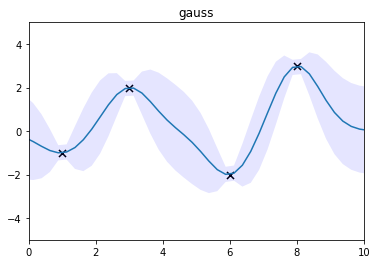

In [97]:
#グラフ化
plt.figure()
plt.xlim(0,10)
plt.ylim(-5.0,5.0)
plt.title('gauss')

#学習データ
plt.scatter(x,y, s=50, c='black',marker='x')

#予測値(期待値)
plt.plot(x_pred,y_pred)

# 2sigma の区間
plt.fill_between(x_pred,sigA,sigB,facecolor='b',alpha=0.1)